In [1]:
####################################################################################################
# CR.GrobsCompare.ipynb
# Karl Lapo July/2015
####################################################################################################
# Plots comparisons between ground observations and radiation products
####################################################################################################

# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

## Import statements
# netcdf/numpy/xray
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xray
import kray

# OS interaction
import sys, pickle, os

# import subplots function for plotting
import seaborn as sns
sns.set_context('poster')
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph

#### Directory Lists
# Unix
if 'linux' in sys.platform:
    dir_pre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dir_pre = '/Users/karllapo/gdrive/'

dir_data = dir_pre+'SnowHydrology/proj/CloudClimatology/data'
dir_print = dir_pre+'SnowHydrology/proj/CloudClimatology/Graphics'

# List of sub-directory names for each data set
dir_NLDAS = '/NLDAS'
dir_SYN = '/CERES_SYN'
dir_grobs = '/GroundObs'
dir_VIC = '/VIC_MTCLIM'
dir_WRF = '/WRF'

# Directory for basemap pickle files
dir_bmap = dir_pre+'SnowHydrology/proj/CloudClimatology/data/basemap'

/home/lapok/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
####################################################################################################
# Functions
####################################################################################################

In [5]:
####################################
## Read previously processed data ##
####################################
# ///// See CC.CA.StatisticsMaps.Master for details on creation of xray data 

###########
## NLDAS ##
os.chdir(dir_data+dir_NLDAS)
nldas = xray.open_dataset('CA.NLDAS.irrad.monthly.nc')
nldas = nldas.rename({'DLWRF_110_SFC':'LWdwn','DSWRF_110_SFC':'SWdwn'})

#########
## SYN ##
os.chdir(dir_data+dir_SYN)
syn = xray.open_dataset('CA.SYN.irrad.monthly.nc')

############
## MTCLIM ##
os.chdir(dir_data+dir_VIC)
mtclim = xray.open_dataset('CA.MTCLIM.irrad.monthly.nc')

#########
## WRF ##
os.chdir(dir_data+dir_WRF)
wrf = xray.open_dataset('CA.WRF.irrad.monthly.nc')
wrf = wrf.rename({'lon':'longitude','lat':'latitude'})

## List w/ all irradiance datasets
monthly_mean = {}
monthly_mean['syn'] = syn
monthly_mean['nldas'] = nldas
monthly_mean['mtclim'] = mtclim
monthly_mean['wrf'] = wrf

# Product names
pr_names = ['mtclim','nldas','syn','wrf']
num_products = np.size(pr_names)
grouping = ['north cv','south cv','west of crest','foothills','east of crest']

#########################
## Ground Observations ##
os.chdir(dir_data)
grobs = xray.open_dataset('grobs.daily.nc')
grobs = grobs.resample(freq='M',dim='time',how='mean')
grobs_diff = xray.Dataset()
for pr in pr_names:
    grobs_diff[pr] = grobs[pr]-grobs.grobs

In [20]:
for pr in pr_names:
    print(pr+': '+str(monthly_mean[pr]['time.year'].values[0])+'/'+str(monthly_mean[pr]['time.month'].values[0])\
            +' to '+\
            str(monthly_mean[pr]['time.year'].values[-1])+'/'+str(monthly_mean[pr]['time.month'].values[-1]))

mtclim: 2000/1 to 2011/12
nldas: 2004/1 to 2010/12
syn: 2002/7 to 2014/5
wrf: 2004/1 to 2014/12


In [11]:
#########################################
## Ground Observation Comparison Plots ##
#########################################
## plotting variables, coordinates, basemap
# colors
SWmin_delta = -50
SWmax_delta = 50
cmap = kgraph.cmap_discretize(cm.gnuplot2,15)
cmap_delta = kgraph.cmap_discretize(cm.RdBu_r,11)

# Build basemap
lat = monthly_mean['mtclim'].latitude.values
lon = monthly_mean['mtclim'].longitude.values

bmp,bmd = kgraph.build_basemap(lon,lat,dir_bmap,'CA.Domain.bmp.pickle',rewrite=True)
lat_labels = bmd['lat_labels']
lon_labels = bmd['lon_labels']

# Station lat and lon
lon_stat = grobs.longitude.values
lat_stat = grobs.latitude.values

## Loop through dates
for d in pd.date_range(start='2011-04-01',end='2011-07-01',freq='M'):
    #################
    ## Color range ##
    SWmax = 0
    SWmin = 500
    for pr in pr_names:
        if monthly_mean[pr].SWdwn.loc[d:d].any() \
            and not np.isnan(np.nanmax(np.squeeze(monthly_mean[pr].SWdwn.loc[d:d].values))).any():
            SWmax = max(np.nanmax(np.squeeze(monthly_mean[pr].SWdwn.loc[d:d].values)),SWmax)
            SWmax = np.round(SWmax/10)*10
        
        if monthly_mean[pr].SWdwn.loc[d:d].any() \
            and np.nanmin(np.squeeze(monthly_mean[pr].SWdwn.loc[d:d].values)) > 0 \
            and not np.isnan(np.nanmin(np.squeeze(monthly_mean[pr].SWdwn.loc[d:d].values))).any():
            SWmin = min(np.nanmin(np.squeeze(monthly_mean[pr].SWdwn.loc[d:d].values)),SWmin)
            SWmin = np.round(SWmin/10)*10
    dSW = 10

    # Create figure
    fig = plt.figure(figsize=(12,6))
    gs = matplotlib.gridspec.GridSpec(2,num_products+2,\
                                      width_ratios=np.append(np.ones(num_products+1)*16,np.array(1.)))
 
    #########################
    ## Ground observations ##
    if monthly_mean[pr].SWdwn.loc[d:d].any():
        ax = plt.subplot(gs[0,0])
        im_avg = bmp.scatter(lon_stat,lat_stat,c=grobs.grobs.loc[d:d].values, \
                                 s=75, cmap=cmap, vmin=SWmin, vmax=SWmax, linewidths=.25,latlon=True)
        
    ## Format
    ax.set_title(('Obs.'))
    bmp.drawparallels(lat_labels,labels=[1,0,0,0])
    bmp.drawmeridians(lon_labels,labels=[0,0,0,1]) 

    # political boundaries.
    bmp.drawstates()
    bmp.drawcoastlines()
    bmp.drawcounties()    
    
    ##############    
    ## Products ##
    for ind,pr in enumerate(pr_names):
        ax = plt.subplot(gs[0,ind+1])             
        if monthly_mean[pr].SWdwn.loc[d:d].any():
            # Lat/Lon handling - product coords
            lon_rad,lat_rad = np.meshgrid(monthly_mean[pr].longitude.values,monthly_mean[pr].latitude.values)
            # Monthly values for each product
            SW_for_plot = np.squeeze(monthly_mean[pr].SWdwn.loc[d:d].values)
            SW_for_plot = np.ma.masked_where(np.isnan(SW_for_plot),SW_for_plot)
            im_avg = bmp.pcolormesh(lon_rad,lat_rad,SW_for_plot,\
                        cmap=cmap,vmin=SWmin,vmax=SWmax,shading='flat',latlon=True,linewidth=0,rasterized=True)
            
        # Format
        ax.set_title((pr))
        bmp.drawparallels(lat_labels)
        bmp.drawmeridians(lon_labels) 
        # political boundaries.
        bmp.drawstates()
        bmp.drawcoastlines()
        bmp.drawcounties()
    
        ## Difference from ground observation values
        ax = plt.subplot(gs[1,ind+1])
        im_dif = bmp.scatter(lon_stat,lat_stat, c=grobs_diff[pr].loc[d:d],\
                        s=75,cmap=cmap_delta,vmin=SWmin_delta,vmax=SWmax_delta,linewidths=.25,latlon=True)

        ## Format
        # Title
        ax.set_title((pr+"- obs."))
        # Axis
        if ind == 0:
            bmp.drawparallels(lat_labels,labels=[1,0,0,0])
        else:
            bmp.drawparallels(lat_labels)
        bmp.drawmeridians(lon_labels,labels=[0,0,0,1])
        # political boundaries.
        bmp.drawstates()
        bmp.drawcoastlines()
        bmp.drawcounties()
    
    ######################
    ## Final formatting ##
    plt.tight_layout
    
    # Colorbar - monthly values
    caxi=plt.subplot(gs[0,-1])
    cbar=plt.colorbar(im_avg, cax=caxi, orientation = "vertical",\
                        ticks=np.arange(SWmin,SWmax+dSW,dSW),spacing='proportional')
    cbar.ax.set_ylabel(('Irradiance (Wm$^{-2}$)'))
    
    # Colorbar - difference
    caxi=plt.subplot(gs[1,-1])
    cbar = plt.colorbar(im_dif, cax=caxi, orientation = "vertical",spacing='proportional')
    cbar.ax.set_ylabel(('Difference (Wm$^{-2}$)'))
            
    fig.tight_layout()
        
    os.chdir(dir_print+'/MonthlyDiff')
    outdate = pd.to_datetime(d) 
    outdate = outdate.strftime('%Y_%m')
    fname = 'GrObs.MonthlyDiff.'+str(outdate)+'.pdf'
    fig.savefig(fname)
    plt.close(fig)

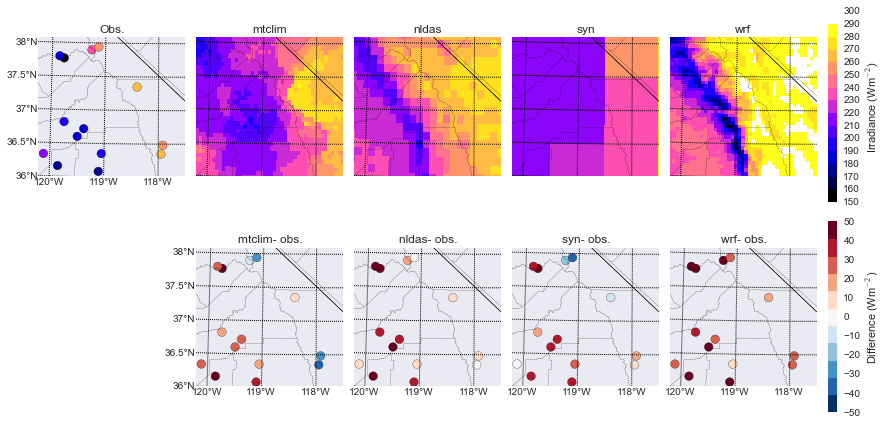

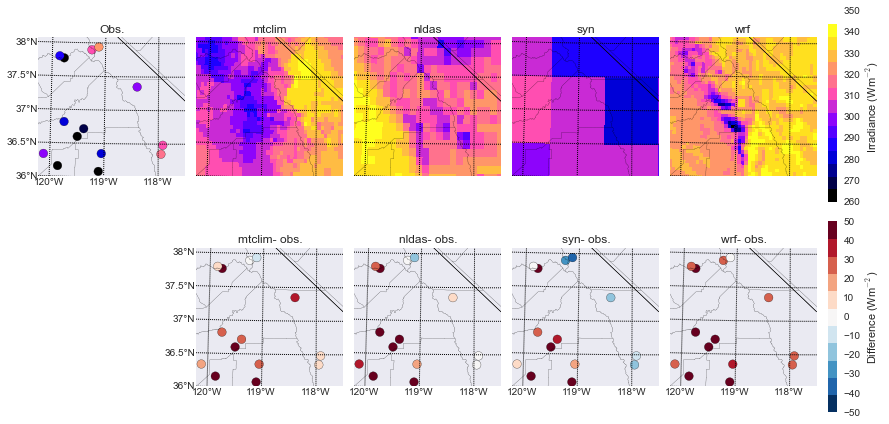

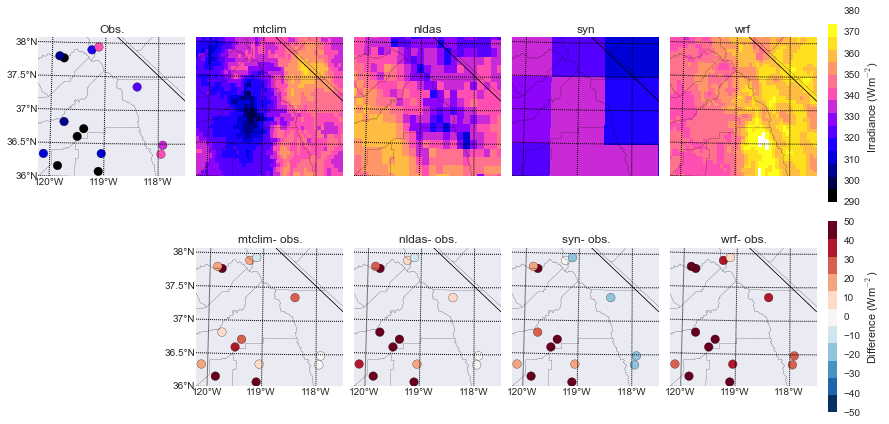

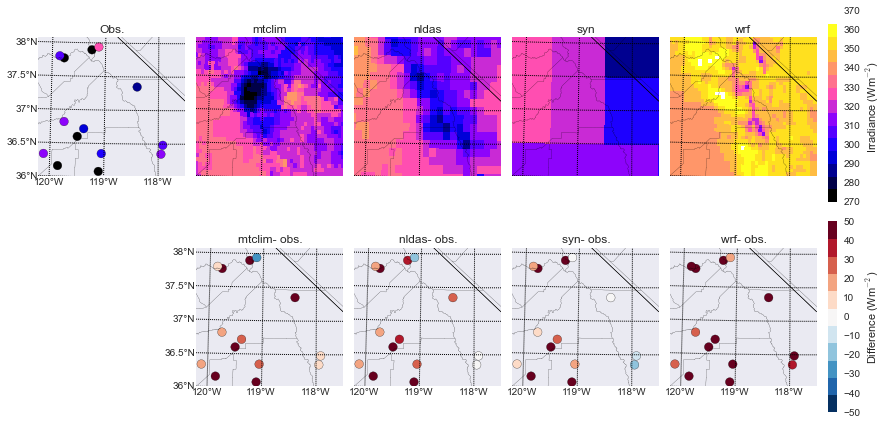

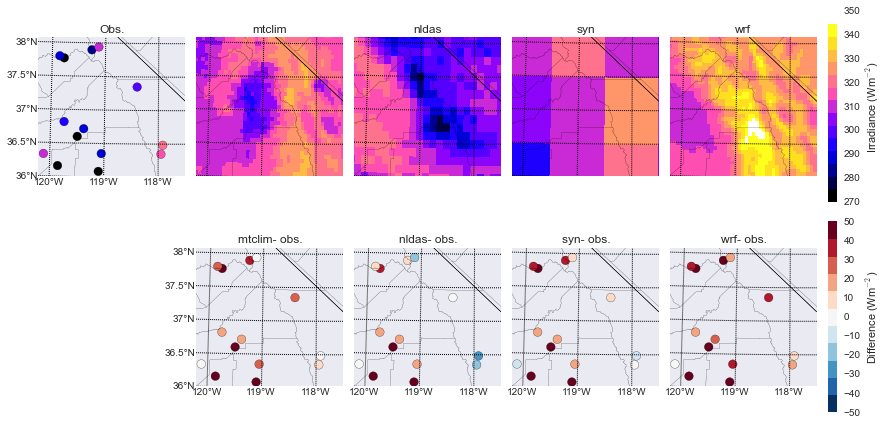

In [34]:
##################################################################
## Ground Observation Comparison Plots -- Mountain Observations ##
##################################################################
## plotting variables, coordinates, basemap
# colors
SWmin_delta = -50
SWmax_delta = 50
cmap = cmap_discretize(cm.gnuplot2,15)
cmap_delta = cmap_discretize(cm.RdBu_r,11)

# Station lat and lon
lon_stat = grobs.longitude.values
lat_stat = grobs.latitude.values

# Lat/Lon handling - map extent
lat = np.array((36,38.1))
lon = np.array((-120.2,-117.5))
bmp,bmd = build_basemap(lon,lat,dir_bmap,'CAMnt.Domain.bmp.pickle',rewrite=False)
lat_labels = np.arange(36,39,.5)
lon_labels = np.arange(-120,-117,1)

## Loop through dates
for d in pd.date_range(start='2006-04-01',end='2006-09-01',freq='M'):
    #################
    ## Color range ##
    SWmax = 0
    SWmin = 500
    for pr in pr_names:
        if monthly_mean[pr].SWdwn.loc[d:d].any() \
            and not np.isnan(np.nanmax(np.squeeze(monthly_mean[pr].SWdwn.loc[d:d].values))).any():
            SWmax = max(np.nanmax(np.squeeze(monthly_mean[pr].SWdwn.loc[d:d].values)),SWmax)
            SWmax = np.round(SWmax/10)*10
        
        if monthly_mean[pr].SWdwn.loc[d:d].any() \
            and np.nanmin(np.squeeze(monthly_mean[pr].SWdwn.loc[d:d].values)) > 0 \
            and not np.isnan(np.nanmin(np.squeeze(monthly_mean[pr].SWdwn.loc[d:d].values))).any():
            SWmin = min(np.nanmin(np.squeeze(monthly_mean[pr].SWdwn.loc[d:d].values)),SWmin)
            SWmin = np.round(SWmin/10)*10
    dSW = 10

    # Create figure
    fig = plt.figure(figsize=(12,6))
    gs = matplotlib.gridspec.GridSpec(2,num_products+2,\
                                      width_ratios=np.append(np.ones(num_products+1)*16,np.array(1.)))
 
    #########################
    ## Ground observations ##
    if monthly_mean[pr].SWdwn.loc[d:d].any():
        ax = plt.subplot(gs[0,0])
        im_avg = bmp.scatter(lon_stat,lat_stat,c=grobs.grobs.loc[d:d].values, \
                                 s=75, cmap=cmap, vmin=SWmin, vmax=SWmax, linewidths=.25,latlon=True)
        
    ## Format
    ax.set_title(('Obs.'))
    bmp.drawparallels(lat_labels,labels=[1,0,0,0])
    bmp.drawmeridians(lon_labels,labels=[0,0,0,1]) 

    # political boundaries.
    bmp.drawstates()
    bmp.drawcoastlines()
    bmp.drawcounties()    
    
    ##############    
    ## Products ##
    for ind,pr in enumerate(pr_names):
        ax = plt.subplot(gs[0,ind+1])             
        if monthly_mean[pr].SWdwn.loc[d:d].any():
            # Lat/Lon handling - product coords
            lon_rad,lat_rad = np.meshgrid(monthly_mean[pr].longitude.values,monthly_mean[pr].latitude.values)
            # Monthly values for each product
            SW_for_plot = np.squeeze(monthly_mean[pr].SWdwn.loc[d:d].values)
            SW_for_plot = np.ma.masked_where(np.isnan(SW_for_plot),SW_for_plot)
            im_avg = bmp.pcolormesh(lon_rad,lat_rad,SW_for_plot,\
                        cmap=cmap,vmin=SWmin,vmax=SWmax,shading='flat',latlon=True)
            
        # Format
        ax.set_title((pr))
        bmp.drawparallels(lat_labels)
        bmp.drawmeridians(lon_labels) 
        # political boundaries.
        bmp.drawstates()
        bmp.drawcoastlines()
        bmp.drawcounties()
    
        ## Difference from ground observation values
        ax = plt.subplot(gs[1,ind+1])
        im_dif = bmp.scatter(lon_stat,lat_stat, c=grobs_diff[pr].loc[d:d],\
                        s=75,cmap=cmap_delta,vmin=SWmin_delta,vmax=SWmax_delta,linewidths=.25,latlon=True)

        ## Format
        # Title
        ax.set_title((pr+"- obs."))
        # Axis
        if ind == 0:
            bmp.drawparallels(lat_labels,labels=[1,0,0,0])
        else:
            bmp.drawparallels(lat_labels)
        bmp.drawmeridians(lon_labels,labels=[0,0,0,1])
        # political boundaries.
        bmp.drawstates()
        bmp.drawcoastlines()
        bmp.drawcounties()
    
    ######################
    ## Final formatting ##
    plt.tight_layout
    
    # Colorbar - monthly values
    caxi=plt.subplot(gs[0,-1])
    cbar=plt.colorbar(im_avg, cax=caxi, orientation = "vertical",\
                        ticks=np.arange(SWmin,SWmax+dSW,dSW),spacing='proportional')
    cbar.ax.set_ylabel(('Irradiance (Wm$^{-2}$)'))
    
    # Colorbar - difference
    caxi=plt.subplot(gs[1,-1])
    cbar = plt.colorbar(im_dif, cax=caxi, orientation = "vertical",spacing='proportional')
    cbar.ax.set_ylabel(('Difference (Wm$^{-2}$)'))
            
    fig.tight_layout()
        
    os.chdir(dir_print+'/MonthlyDiff')
    outdate = pd.to_datetime(d) 
    outdate = outdate.strftime('%Y_%m')
    fname = 'GrObs_Mountain.MonthlyDiff.'+str(outdate)+'.png'
    fig.savefig(fname)
#     plt.close(fig)

In [23]:
#########################################################
## Monthly diff shortwave w/ elevation - scatter plots ##
#########################################################
month_label = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
elev = grobs.elev.values
for YYYY in np.arange(2002,2014):
    f, axes = plt.subplots(3, 4, figsize=(12, 9), sharex=True, sharey=True)
    for ax,m in zip(axes.flat, np.arange(1,13)):
        for pr in pr_names:
            if pr == 'grobs':
                continue
            if m == 12:
                d = pd.date_range(start=(str(YYYY)+'-'+str(m)+'-1'),end=(str(YYYY+1)+'-'+str(1)+'-1'),freq='M')
            else:
                d = pd.date_range(start=(str(YYYY)+'-'+str(m)+'-1'),end=(str(YYYY)+'-'+str(m+1)+'-1'),freq='M')
            im = ax.plot(elev,\
                         np.squeeze(grobs[pr].loc[d[0]:d[0]].values-grobs.SWdwn.loc[d[0]:d[0]].values),\
                         '.',label=pr)
        
        # Labels and legend
        if m == 1:
            ax.legend(ncol=3,labelspacing=.25,markerscale=2,numpoints=1,columnspacing=.3,frameon=True)       
        if np.mod(((m-1)+4),4) == 0:
            ax.set_ylabel('Bias (Wm$^{-2}$)')
        if m > 8:        
            ax.set_xlabel('Station Elevation (m)')    
        ax.plot(np.array([0,3500]),np.array([0,0]),'k--')
        ax.set_title(month_label[m-1]) 
        ax.set_ylim([-40,80])
    f.tight_layout()
    
    os.chdir(dir_print)
    fname = 'SWdwn_scatter_elev.scatter.'+str(YYYY)+'.png'
    f.savefig(fname)
    plt.close(f)


In [36]:
##############################################
## Violin (OLD, pre-function)
## Elevation -- Monthly Bias
##############################################
# Formatting variables
month_label = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
bins = np.array((0,50,100,800,1200,4000))
bin_centers = np.array((25,75,450,1000,2600))
bin_labels = ['0-50','50-100','100-800','800-1200','1200+']
bin_pos = np.array([[1,2,3,4],[7,8,9,10],[13,14,15,16],[19,20,21,22],[25,26,27,28]])
colsche = np.array([[68.,119.,170.],\
                [17.,119.,71.],\
                [221.,204.,119.],\
                [204.,102.,119.]])
colsche = np.divide(colsche,256.)
violinplotlines = ['cbars','cmins','cmeans','cmaxes']

for YYYY in np.arange(2004,2010):
    f, axes = plt.subplots(3, 4, figsize=(15, 9), sharex=True, sharey=True)
    for ax,m in zip(axes.flat, np.arange(1,13)):            
        ## Build xray structure for violinplot
        prod_ds = {}
        for n,pr in enumerate(pr_names):  
            # Get values for year
            if pr == 'grobs':
                continue
            if m == 12:
                d = pd.date_range(start=(str(YYYY)+'-'+str(m)+'-1'),end=(str(YYYY+1)+'-'+str(1)+'-1'),freq='M')
            else:
                d = pd.date_range(start=(str(YYYY)+'-'+str(m)+'-1'),end=(str(YYYY)+'-'+str(m+1)+'-1'),freq='M')
            
            # Product bias
            grobs_diff = np.squeeze(grobs[pr].loc[d[0]:d[0]].values-grobs.SWdwn.loc[d[0]:d[0]].values)
            # Skip years w/out data
            if not grobs[pr].loc[d[0]:d[0]].values.any():
                continue
            elev = grobs.elev.values
            # Remove nans
            nandex = np.nonzero(~np.isnan(grobs_diff))
            grobs_diff = grobs_diff[nandex]
            elev = elev[nandex]
            # Find elevation bin
            if np.isnan(grobs_diff).all():
                continue
            digitized = np.digitize(elev, bins)
            digi_elev = bin_centers[digitized-1]    
            # Buid dataset
            prod_ds[pr] = xray.Dataset({'bias':(['elev'],grobs_diff)},\
                            coords={'elev': (['elev'],digi_elev)})

        # Tidy up
        diff_da = xray.concat([prod_ds['mtclim'],prod_ds['nldas'],prod_ds['syn'],prod_ds['wrf']],dim='product')
        diff_da.coords['product'] = ['mtclim','nldas','syn','wrf']
        
        ## Plotting
        # In future: find a way to make line color and body area agree
        for n,bc in enumerate(bin_centers):
            ## Violin plots
            dat_for_plot= diff_da.bias.loc[{'elev':bc}].values
            result = ax.violinplot(dat_for_plot.T,positions=np.array((bin_pos[n])),showmeans=True,widths=1)
        
            ## Format
            # Violin body
            for n,pc in enumerate(result['bodies']):
                pc.set_facecolor(colsche[n])
                pc.set_edgecolor(colsche[n])
                pc.set_alpha(None)
            # Violin lines
            pc = result['cbars']
            for vpl in violinplotlines:
                result[vpl].set_color('k')
            # Violinplot labels
            pr_names_for_legend = [pr for pr in pr_names if not pr == 'grobs']
            handle = [matplotlib.patches.Patch(color=colsche[n], label=pr_names_for_legend[n]) \
                      for n,p in enumerate(pr_names_for_legend)]
            # Violin lines
            pc = result['cbars']
            for vpl in violinplotlines:
                result[vpl].set_color('k')

            
        # Labels and legend
        if m == 1:
            ax.legend(handles=handle,ncol=num_products,labelspacing=.25,columnspacing=.3)
        # Labels and legend
        ax.plot(np.array([0,24]),np.array([0,0]),'k--')
        ax.set_xticks(bin_pos[:,1])
        ax.set_ylim([-80,80])     
        if np.mod(((m-1)+4),4) == 0:
            ax.set_ylabel('Bias (Wm$^{-2}$)')
        if m > 8:        
            ax.set_xticklabels(bin_labels);
            ax.set_xlabel('elevation band (m)')
        ax.set_title(month_label[m-1]) 
    
    f.tight_layout()
    
    os.chdir(dir_print)
    fname = 'SWdwn_scatter_elev.violin.'+str(YYYY)+'.png'
    f.savefig(fname)
    plt.close(f)


In [12]:
##############################################
## Violin (OLD, pre-function)
## Station Groups -- Monthly Bias
##############################################
# Formatting variables
# month_label = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
# grouping = ['north cv','south cv','foothills','west of crest','east of crest']
# gr_label = ['NCV','SCV','FHLLS','WC','EC']
# bin_pos = np.array([[1,2,3,4],[7,8,9,10],[13,14,15,16],[19,20,21,22],[25,26,27,28]])
# colsche = np.array([[68.,119.,170.],\
#                 [17.,119.,71.],\
#                 [221.,204.,119.],\
#                 [204.,102.,119.]])

# colsche = np.divide(colsche,256.)
# violinplotlines = ['cbars','cmins','cmeans','cmaxes']

# for YYYY in np.arange(2010,2013):
#     f, axes = plt.subplots(3, 4, figsize=(15, 9), sharex=True, sharey=True)
#     for ax,m in zip(axes.flat, np.arange(1,13)):            
#         ## Build xray structure for violinplot
#         prod_ds = {}
#         for n,pr in enumerate(pr_names):  
#             # Get values for year
#             if pr == 'grobs':
#                 continue
#             if m == 12:
#                 d = pd.date_range(start=(str(YYYY)+'-'+str(m)+'-1'),end=(str(YYYY+1)+'-'+str(1)+'-1'),freq='M')
#             else:
#                 d = pd.date_range(start=(str(YYYY)+'-'+str(m)+'-1'),end=(str(YYYY)+'-'+str(m+1)+'-1'),freq='M')
            
#             # Product bias
#             grobs_diff = np.squeeze(grobs[pr].loc[d[0]:d[0]].values-grobs.SWdwn.loc[d[0]:d[0]].values)
#             # Remove nans
#             nandex = np.nonzero(~np.isnan(grobs_diff))
#             grobs_diff = grobs_diff[nandex]
#             ds_group = grobs.Grouping.values[nandex]
#             # Buid dataset
#             prod_ds[pr] = xray.Dataset({'bias':(['group'],grobs_diff)},\
#                             coords={'group': (['group'],ds_group)})

#         # Tidy up
#         diff_da = xray.concat([prod_ds['mtclim'],prod_ds['nldas'],prod_ds['syn'],prod_ds['wrf']],dim='product')
#         diff_da.coords['product'] = ['mtclim','nldas','syn','wrf']
        
#         ## Plotting
#         # In future: find a way to make line color and body area agree
#         for n,gr in enumerate(grouping):
#             ## Violin plots
#             dat_for_plot= diff_da.bias.loc[{'group':gr,}].values
#             if dat_for_plot.size <=4:
#                 continue
#             result = ax.violinplot(dat_for_plot.T,positions=np.array((bin_pos[n])),showmeans=True,widths=1)
        
#             ## Format
#             # Violin body
#             for n,pc in enumerate(result['bodies']):
#                 pc.set_facecolor(colsche[n])
#                 pc.set_edgecolor(colsche[n])
#                 pc.set_alpha(None)
#             # Violin lines
#             pc = result['cbars']
#             for vpl in violinplotlines:
#                 result[vpl].set_color('k')
#         pr_names_for_legend = [pr for pr in pr_names if not pr == 'grobs']
#         handle = [matplotlib.patches.Patch(color=colsche[n], label=pr_names_for_legend[n]) \
#                       for n,p in enumerate(pr_names_for_legend)]
        
#         # Labels and legend
#         if m == 1:
#             ax.legend(handles=handle,ncol=num_products,labelspacing=.25,columnspacing=.3)
#         ax.plot(np.array([0,bin_pos.max()]),np.array([0,0]),'k--')
#         ax.set_xticks(bin_pos[:,1])
#         ax.set_ylim([-80,80])
#         if np.mod(((m-1)+4),4) == 0:
#             ax.set_ylabel('Bias (Wm$^{-2}$)')
#         if m > 8:        
#             ax.set_xticklabels(gr_label);
#             ax.set_xlabel('Station Classificaiton')
#         ax.set_title(month_label[m-1]) 
    
#     f.tight_layout()
    
#     os.chdir(dir_print)
#     fname = 'SWdwn_violin.groups'+str(YYYY)+'.png'
#     f.savefig(fname)
#     plt.close(f)


In [ ]:
##############################################
## Monthly diff shortwave w/ group - violin ##
##############################################
# Formatting variables
month_label = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
grouping = ['north cv','south cv','foothills','west of crest','east of crest']
gr_label = ['NCV','SCV','FHLLS','WC','EC']
bin_pos = np.array([[1,2,3,4],[7,8,9,10],[13,14,15,16],[19,20,21,22],[25,26,27,28]])
colsche = np.array([[68.,119.,170.],\
                [17.,119.,71.],\
                [221.,204.,119.],\
                [204.,102.,119.]])

colsche = np.divide(colsche,256.)
violinplotlines = ['cbars','cmins','cmeans','cmaxes']

#### Re-do, building structure outside loop. Select date inside loop. Select group inside loop.
# This allows the structure to be aligned along date so that all fields are the same length


## Build xray structure for violinplot
prod_ds = {}
for n,pr in enumerate(pr_names):  
    # Get values for year
    if pr == 'grobs':
        continue
    # Product bias
    grobs_diff = grobs[pr]-grobs.SWdwn
   
    # Buid dataset
    prod_ds[pr] = xray.Dataset({'bias':(['group'],grobs_diff)},\
                    coords={'group': (['group'],ds_group)})

# Tidy up
diff_da = xray.concat([prod_ds['mtclim'],prod_ds['nldas'],prod_ds['syn'],prod_ds['wrf']],dim='product')
diff_da.coords['product'] = ['mtclim','nldas','syn','wrf']

for YYYY in np.arange(2004,2004):
    f, axes = plt.subplots(3, 4, figsize=(15, 9), sharex=True, sharey=True)
    for ax,m in zip(axes.flat, np.arange(1,13)):            
        if m == 12:
            d = pd.date_range(start=(str(YYYY)+'-'+str(m)+'-1'),end=(str(YYYY+1)+'-'+str(1)+'-1'),freq='M')
        else:
            d = pd.date_range(start=(str(YYYY)+'-'+str(m)+'-1'),end=(str(YYYY)+'-'+str(m+1)+'-1'),freq='M')

        dat_for_plot = diff_da.bias.loc[d[0]:d[0]]
        
         # Remove nans ????
        nandex = np.nonzero(~np.isnan(grobs_diff))
        grobs_diff = grobs_diff[nandex]
        ds_group = grobs.Grouping.values[nandex]
        
        ## Plotting
        # In future: find a way to make line color and body area agree
        for n,gr in enumerate(grouping):
            ## Violin plots
            result = ax.violinplot(dat_for_plot.loc[{'group':gr,}].values.T,\
                                   positions=np.array((bin_pos[n])),showmeans=True,widths=1)
        
            ## Format
            # Violin body
            for n,pc in enumerate(result['bodies']):
                pc.set_facecolor(colsche[n])
                pc.set_edgecolor(colsche[n])
                pc.set_alpha(None)
            # Violin lines
            pc = result['cbars']
            for vpl in violinplotlines:
                result[vpl].set_color('k')
        pr_names_for_legend = [pr for pr in pr_names if not pr == 'grobs']
        handle = [matplotlib.patches.Patch(color=colsche[n], label=pr_names_for_legend[n]) \
                      for n,p in enumerate(pr_names_for_legend)]
        
        # Labels and legend
        if m == 1:
            ax.legend(handles=handle,ncol=num_products,labelspacing=.25,columnspacing=.3)
        ax.plot(np.array([0,bin_pos.max()]),np.array([0,0]),'k--')
        ax.set_xticks(bin_pos[:,1])
        ax.set_ylim([-80,80])
        if np.mod(((m-1)+4),4) == 0:
            ax.set_ylabel('Bias (Wm$^{-2}$)')
        if m > 8:        
            ax.set_xticklabels(gr_label);
            ax.set_xlabel('Station Classificaiton')
        ax.set_title(month_label[m-1]) 
    
    f.tight_layout()
    
#     os.chdir(dir_print)
#     fname = 'SWdwn_violin.groups'+str(YYYY)+'.png'
#     f.savefig(fname)
#     plt.close(f)

In [52]:
############################################
## Time series of irradiance by longitude ##
############################################
# formating preface
colsche = kgraph.SRON(5)
month_label = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

# Transect limits
lat_bottom = 37
lat_top = 38
lon_left = 122
lon_right = 118

for YYYY in np.arange(2004,2012):
    f, axes = plt.subplots(3, 4, figsize=(15, 9))#, sharex=True, sharey=True)
    for ax,m in zip(axes.flat, np.arange(1,13)):            
        # Get values for year
        if m == 12:
            d = pd.date_range(start=(str(YYYY)+'-'+str(m)+'-1'),end=(str(YYYY+1)+'-'+str(1)+'-1'),freq='M')
        else:
            d = pd.date_range(start=(str(YYYY)+'-'+str(m)+'-1'),end=(str(YYYY)+'-'+str(m+1)+'-1'),freq='M')
        
        for n,pr in enumerate(pr_names):
            irrad_values = np.squeeze(monthly_mean[pr].SWdwn.loc[d[0]:d[0]].values)
            if pr == 'grobs':
                loni_r = (monthly_mean[pr].longitude<-lon_right).values
                loni_l = (monthly_mean[pr].longitude>-lon_left).values
                lati_b = (monthly_mean[pr].latitude>lat_bottom).values
                lati_t = (monthly_mean[pr].latitude<lat_top).values
                index_array = np.logical_and.reduce(np.array((loni_r,loni_l,lati_b,lati_t)))
                index_array = np.nonzero(index_array)
                
                irrad_values = irrad_values[index_array]
                lon_values = monthly_mean[pr].longitude.values[index_array]
            else:
                ind_lon = np.flatnonzero((monthly_mean[pr].longitude.values<-lon_right) \
                                 & (monthly_mean[pr].longitude.values>-lon_left))
                ind_lat = np.flatnonzero((monthly_mean[pr].latitude.values>lat_bottom) \
                                 & (monthly_mean[pr].latitude.values>lat_bottom))
                irrad_values = np.squeeze(monthly_mean[pr].SWdwn.loc[{'time':d[0]}].values)
                irrad_values = irrad_values[ind_lat[0]:ind_lat[-1]+1,ind_lon[0]:ind_lon[-1]+1]
                irrad_values = np.nanmean(irrad_values,axis=0)
                lon_values = monthly_mean[pr].longitude.values[ind_lon]
                
            # plot
            ax.plot(lon_values,irrad_values,'.',color=colsche[n],label=pr)
    
            # Labels and legend
            if m == 1:
                ax.legend(ncol=2,labelspacing=.25,markerscale=2,numpoints=1,columnspacing=.3,frameon=True)   
            # Labels
            ax.set_title(month_label[m-1])
            if np.mod((m+3),4) == 0:
                ax.set_ylabel('Mean $Q_{si}$ (Wm$^{-2}$)')
            if m > 8:        
                ax.set_xlabel('Longitude')
            else:
                ax.tick_params(axis='x',which='both',labelbottom='off')        
    os.chdir(dir_print)
    fname = 'SWdwn_transect.'+str(YYYY)+'.png'
    f.savefig(fname)
    plt.close(f)


(array([ 3,  4,  6, 14, 17, 18, 28, 30, 32, 33, 35, 36, 38, 41, 43, 44, 45,
       46, 47, 48, 50, 56, 57, 60, 62, 63, 64, 66, 67, 71]),)
{'grobs': <xray.Dataset>
Dimensions:    (station: 73, time: 157)
Coordinates:
    network    (station) |S9 'CIMIS_IPM' 'CIMIS_IPM' 'CIMIS_IPM' 'CDWR' ...
    longitude  (station) float64 -119.5 -118.8 -121.1 -118.3 -118.4 -120.0 ...
  * station    (station) |S19 'Alpaugh' 'ARVIN' 'Auburn' 'bee' 'BISHOP' ...
    elev       (station) float64 64.0 152.0 285.0 2.768e+03 1.271e+03 215.0 ...
  * time       (time) datetime64[ns] 2002-10-31 2002-11-30 2002-12-31 ...
    latitude   (station) float64 35.87 35.2 38.88 37.53 37.35 35.65 37.93 ...
    Grouping   (station) |S13 'south cv' 'foothills' 'foothills' ...
Data variables:
    SWdwn      (time, station) float64 nan nan nan nan nan nan nan nan nan ..., 'syn': <xray.Dataset>
Dimensions:        (latitude: 8, longitude: 9, time: 143)
Coordinates:
  * longitude      (longitude) float32 -123.5 -122.5 -121.5 -12

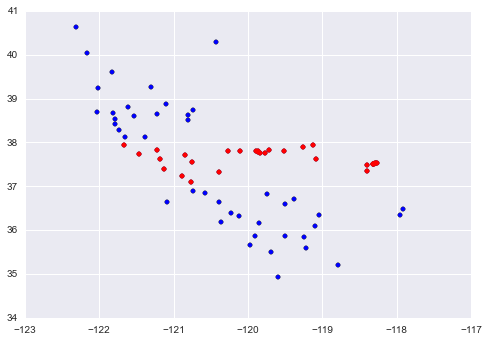

In [209]:
# Transect limits
lat_bottom = 37
lat_top = 38
lon_left = -122
lon_right = -118

loni_r = (grobs['longitude']<-118).values
loni_l = (grobs['longitude']>-122).values
lati_b = (grobs.latitude>lat_bottom).values
lati_t = (grobs.latitude<lat_top).values
index_array = np.logical_and.reduce(np.array((loni_r,loni_l,lati_b,lati_t)))
index_array = np.nonzero(index_array)
print(index_array)


plt.scatter(grobs.longitude.values,grobs.latitude.values)
plt.scatter(grobs.longitude.values[index_array],grobs.latitude.values[index_array],color='r')

print(monthly_mean)

KeyError: 'grobs'

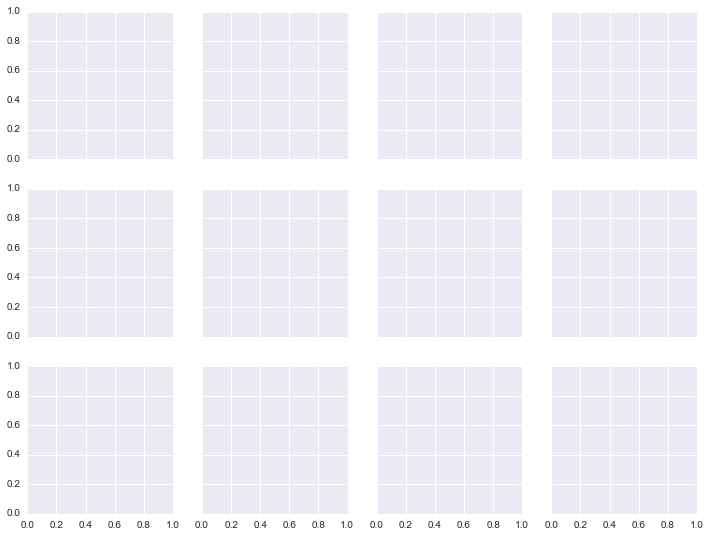

In [41]:
################################
## Mean Shortwave Comparisons ##
################################
colsche =   np.array([[68.,119.,170.],\
            [221.,204.,119.],\
            [204.,102.,119.]])
colsche = np.divide(colsche,256.)

for ind,pr in enumerate(pr_names):  
    f, axes = plt.subplots(3, 4, figsize=(12, 9), sharex=True, sharey=True)
    for ax,YYYY in zip(axes.flat, np.arange(2002,2014)):
        # datetime object spanning given year
        d = pd.date_range(start=(str(YYYY)+'-01-01'),end=(str(YYYY+1)+'-01-01'),freq='M')
        # Scatter plot of obs to model values
        im = ax.plot(np.squeeze(grobs[pr].loc[d[0]:d[-1]].values),\
                     np.squeeze(grobs.SWdwn.loc[d[0]:d[-1]].values),'.',label=pr,color=colsche[0,:])
        # One-to-one line
        ax.plot(np.arange(0,400),np.arange(0,400),'k--')
        
        # Labels and legend     
        if np.mod(((YYYY-2002)+4),4) == 0:
            ax.set_ylabel('Modeled (Wm$^{-2}$)')
        if YYYY-2002 > 8:        
            ax.set_xlabel('Ground Obs (Wm$^{-2}$)')    
        ax.set_title(str(YYYY)) 
        ax.set_xlim([0,400])
        ax.set_ylim([0,400])
    f.tight_layout()
    
    os.chdir(dir_print)
    fname = 'SWdwn_scatter.'+pr+'.png'
    f.savefig(fname)
    plt.close(f)
